In [1]:
from utils import calculate_two_peaks_probability, sig, sigfit

## Experimental Data

In [2]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

## TODO double check fit values

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

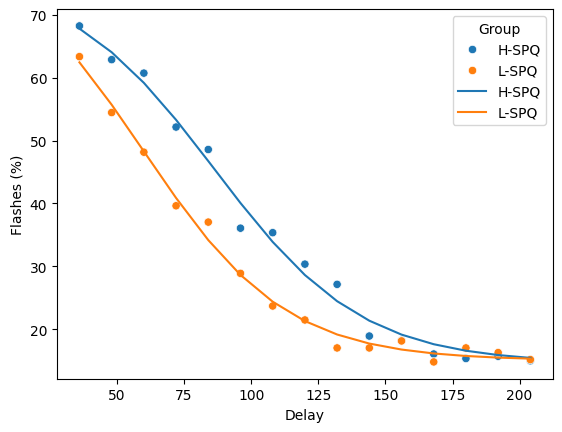

In [3]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

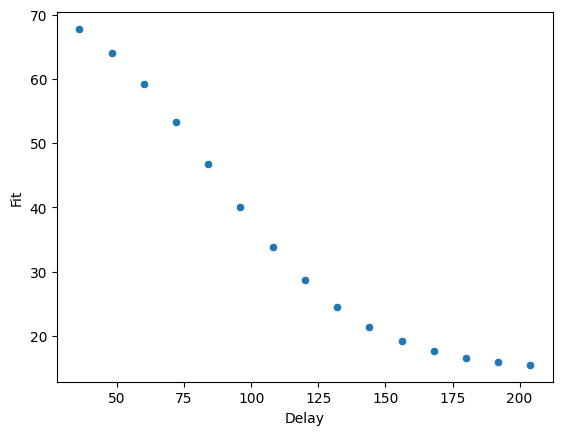

In [5]:
# Data to fit
hspq_data = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay")

## Fitting

In [ ]:
from skneuromsi.neural import Paredes2022
from joblib import Parallel, delayed
import numpy as np
from scipy.optimize import differential_evolution
from findpeaks import findpeaks


def myjob(soa, l_ex):
    model = Paredes2022(
        time_range=(0, 550),
        neurons=30,
        position_range=(0, 30),
        tau=(6.712e00, 2.356e01, 1.175e02),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        lateral_excitation=l_ex,
        cross_modal_weight=1.327e-02,
        feedback_weight=2.423e-01,
        feedforward_weight=2.461e00,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    max_pos = res.stats.dimmax().positions
    fp_results = fp.fit(
        res.get_modes(include="visual").query(f"positions=={max_pos}").visual.values
    )
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes


def hspq_cost(theta):
    two_flashes = []
    for soa in soas:
        two_flashes_per_soa = myjob(soa=soa, l_ex=theta[0])
        two_flashes.append(two_flashes_per_soa)

    model_data = np.array(two_flashes) * 100
    exp_data = hspq_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(1.5, 1.7)]
hspq_fit_res = differential_evolution(
    hspq_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)

differential_evolution step 1: f(x)= 0.0667248
differential_evolution step 2: f(x)= 0.0550032
differential_evolution step 3: f(x)= 0.0550032
differential_evolution step 4: f(x)= 0.0550032
differential_evolution step 5: f(x)= 0.0550032
differential_evolution step 6: f(x)= 0.0549122
differential_evolution step 7: f(x)= 0.0549035
differential_evolution step 8: f(x)= 0.0548751


In [27]:
print(hspq_fit_res)

 message: Optimization terminated successfully.
 success: True
     fun: 0.05487507446394833
       x: [ 1.632e+00]
     nit: 8
    nfev: 135


## Exploration

In [ ]:
from skneuromsi.neural import Paredes2022
import numpy as np
from findpeaks import findpeaks


def myjob_explore(soa, cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau):
    model = Paredes2022(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        auditory_soa=soa,
        noise=False,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        lateral_excitation=1.632e00,
        cross_modal_latency=16,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    max_pos = res.stats.dimmax().positions
    fp_results = fp.fit(
        res.get_modes(include="visual").query(f"positions=={max_pos}").visual.values
    )
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes, res

In [34]:
from joblib import Parallel, delayed

with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_explore)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02
        )
        for soa in soas
    )

two_flashes = [i[0] for i in par_res]
results = [i[1] for i in par_res]

fb_raw_model_data = np.array(two_flashes) * 100

In [35]:
sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, fb_raw_model_data)
print(a, b, c, d)
fb_model_data = sig(sig_soas, a, b, c, d)

15.147090412535725 45.35762635731802 102.53709353228533 -20.708480941392246


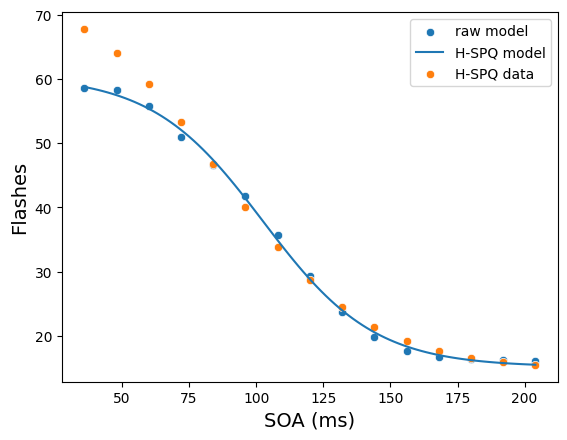

In [36]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=fb_raw_model_data, label="raw model")
sns.lineplot(x=sig_soas, y=fb_model_data, label="H-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay", label="H-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

In [33]:
def adjrmse(model, data, k):
    sse = np.sum(np.square(data - model))
    n = len(model)
    return np.sqrt(sse / (n - k))


scz_error = adjrmse(fb_raw_model_data, dataset.query("Group == 'H-SPQ'").Fit.values, 1)
print(scz_error)

32.09356254995928
